<a href="https://colab.research.google.com/github/AshaNatty/Gen-AI-Workshop/blob/main/Vision_(Prerequisites_before_GenAI_Workshop).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1 style="color:#6C3483" align="center">1. Transfer Learning: Fine Tuning and Feature Extraction</h1>

# Convolutional Neural Network (CNN)

In [ ]:
# Pytorch libraries for deep learning and computer vision
import torch
import torchvision
import torchvision.transforms as transforms

# For displaying images and numpy operations
import matplotlib.pyplot as plt
import numpy as np

# For CNN Purpose
import torch.nn as nn
import torch.nn.functional as F

# Loss function and optimizer
import torch.optim as optim

###### Initializing Data Loader

The output of torchvision datasets are PILImage images of range [0, 1]. We transform them to Tensors of normalized range [-1, 1]

In [ ]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100%|██████████| 170M/170M [00:40<00:00, 4.21MB/s]


###### Functions to show an image

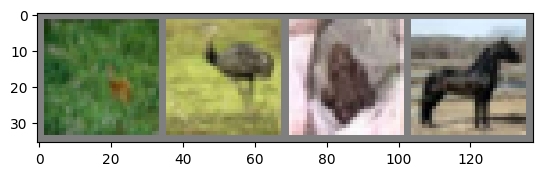

 deer  bird  frog horse


In [ ]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)
# print(labels)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

##### Define a Convolution Neural Network without Drop Out

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(2, 2)

        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(120, 84)
        self.relu4 = nn.ReLU()
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)
        x3 = x.view(-1, 16 * 5 * 5)
        x = self.fc1(x3)
        x = self.relu3(x)
        x2 = self.fc2(x)
        x = self.relu4(x2)
        x = self.fc3(x)
        return (x3, x2, x)

net = Net()

In [ ]:
print(net)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (relu3): ReLU()
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (relu4): ReLU()
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


In [ ]:
# Using GPU, if available
use_gpu = torch.cuda.is_available()
print(use_gpu)

if use_gpu:
    net.cuda()

True


##### Define Loss function and optimizer

In [ ]:
# Let’s use a Classification Cross-Entropy loss and SGD with momentum
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

###### Train the network

In [ ]:
# This is when things start to get interesting.
# We simply have to loop over our data iterator, and feed the inputs to the network and optimize

for epoch in range(1):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data

        # wrap them in Variable
        if use_gpu:
            inputs, labels = inputs.cuda(), labels.cuda()
        else:
            inputs, labels = inputs, labels

        # zero the parameter gradients
        optimizer.zero_grad()

        feature1, features, outputs = net(inputs)

        # forward + backward + optimize
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.223
[1,  4000] loss: 1.909
[1,  6000] loss: 1.666
[1,  8000] loss: 1.589
[1, 10000] loss: 1.541
[1, 12000] loss: 1.474
Finished Training


In [ ]:
# Saving the model
torch.save(net.state_dict(), 'cifar10Model.pth')

In [ ]:
# Loading the model
net.load_state_dict(torch.load('cifar10Model.pth'))

<All keys matched successfully>

In [ ]:
# Set model to evaluation mode
net.eval()

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (relu3): ReLU()
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (relu4): ReLU()
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

# Feature Extraction and Classification using CNN

We have trained the network for 2 passes over the training dataset. But we need to check if the network has learnt anything at all.

We will check this by predicting the class label that the neural network outputs, and checking it against the ground-truth. If the prediction is correct, we add the sample to the list of correct predictions.

In [ ]:
dataiter = iter(testloader)
images, labels = next(dataiter)
images, labels = images.cuda(), labels.cuda()

Okay, first step. Let us display an image from the test set to get familiar.

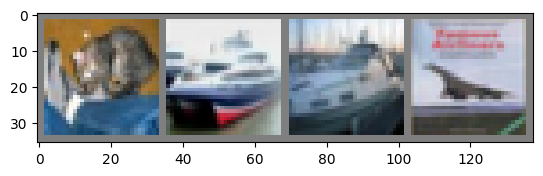

GroundTruth:    cat  ship  ship plane


In [ ]:
# print images
imshow(torchvision.utils.make_grid(images.cpu()))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

Okay, now let us see what the neural network thinks these examples above are:

In [ ]:
images = images.to('cuda')
_, _, outputs = net(images)
# outputs = F.softmax(outputs)
#outputs = outputs.cpu()

The outputs are energies for the 10 classes. Higher the energy for a class, the more the network thinks that the image is of the particular class. So, let’s get the index of the highest energy:

In [ ]:
_, predicted = torch.max(outputs.data, 1)
predicted = predicted.cpu().numpy()
className = list(classes)
print('Predicted: ', ' '.join('%5s' % className[predicted[j]]
                              for j in range(4)))

Predicted:    cat   car   car  ship


The results seem pretty good with only one epoch.

Let us look at how the network performs on the whole dataset.

In [ ]:
correct = 0
total = 0
for data in testloader:
    images, labels = data
    images, labels = images.cuda(), labels.cuda()
    _, _, outputs = net(images)
#     outputs = F.softmax(outputs)
    outputs = outputs.cpu()
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels.cpu()).sum()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 48 %


In [ ]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
for data in testloader:
    images, labels = data
    images, labels = images.cuda(), labels.cuda()
    _, _, outputs = net(images)
#     outputs = F.softmax(outputs)
    outputs = outputs.cpu()
    _, predicted = torch.max(outputs.data, 1)
    c = (predicted == labels.cpu()).squeeze()
    for i in range(4):
        label = labels[i]
        class_correct[label] += c[i]
        class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 39 %
Accuracy of   car : 64 %
Accuracy of  bird : 24 %
Accuracy of   cat : 29 %
Accuracy of  deer : 50 %
Accuracy of   dog : 28 %
Accuracy of  frog : 64 %
Accuracy of horse : 62 %
Accuracy of  ship : 60 %
Accuracy of truck : 65 %


# Feature Extraction using CNN

<b>Train Set of CIFAR-10 Dataset</b>

In [ ]:
for i, data in enumerate(trainloader, 0):
    # get the inputs
    inputs, labels = data

    # wrap them in Variable
    if use_gpu:
        inputs, labels = inputs.cuda(), labels.cuda()
    else:
        inputs, labels = inputs, labels

    # extracting features
    _, features, _ = net(inputs)

    if use_gpu:
        features = features.cpu()
        labels = labels.cpu()
    feature = features.data.numpy()
    label = labels.data.numpy()
    label = np.reshape(label,(labels.size(0),1))

    if i==0:
        featureMatrix = np.copy(feature)
        labelVector = np.copy(label)
    else:
        featureMatrix = np.vstack([featureMatrix,feature])
        labelVector = np.vstack([labelVector,label])

print('Finished Feature Extraction for Train Set')

Finished Feature Extraction for Train Set


<b>Test Set of CIFAR-10 Dataset</b>

In [ ]:
for i, data in enumerate(testloader, 0):
    # get the inputs
    inputs, labels = data

    # wrap them in Variable
    if use_gpu:
        inputs, labels = inputs.cuda(), labels.cuda()
    else:
        inputs, labels = inputs, labels

    # extracting features
    _, features, _ = net(inputs)

    if use_gpu:
        features = features.cpu()
        labels = labels.cpu()
    feature = features.data.numpy()
    label = labels.data.numpy()
    label = np.reshape(label,(labels.size(0),1))

    if i==0:
        featureMatrixTest = np.copy(feature)
        labelVectorTest = np.copy(label)
    else:
        featureMatrixTest = np.vstack([featureMatrixTest,feature])
        labelVectorTest = np.vstack([labelVectorTest,label])

print('Finished Feature Extraction for Test Set')

Finished Feature Extraction for Test Set


# Classification Using Random Forest

In [ ]:
# Import Packages for Random Forest
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
import joblib

from sklearn.ensemble import RandomForestClassifier

In [ ]:
# Defining Random Forest Claasifier
clf = RandomForestClassifier(n_estimators = 100)
print(clf.get_params())

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}


In [ ]:
# Train the Random Forest using Train Set of CIFAR-10 Dataset
clf.fit(featureMatrix, np.ravel(labelVector))

RandomForestClassifier()

In [ ]:
# Test with Random Forest for Test Set of CIFAR-10 Dataset
labelVectorPredicted = clf.predict(featureMatrixTest)

##### Glimpse of Classifcation Results

In [ ]:
labelVectorTest = np.ravel(labelVectorTest)
className = list(classes)
for i in range(10):
    print(className[labelVectorTest[i]], className[labelVectorPredicted[i]])

cat bird
ship car
ship ship
plane ship
frog frog
frog frog
car bird
frog deer
cat cat
car car


##### Classification Performance over Whole Test Dataset

In [ ]:
correct = (labelVectorPredicted == labelVectorTest).sum()
print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / labelVectorTest.shape[0]))

Accuracy of the network on the 10000 test images: 53 %


In [ ]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
c = (labelVectorPredicted == labelVectorTest).squeeze()
for i in range(labelVectorTest.shape[0]):
    label = labelVectorTest[i]
    class_correct[label] += c[i]
    class_total[label] += 1

for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 54 %
Accuracy of   car : 68 %
Accuracy of  bird : 38 %
Accuracy of   cat : 37 %
Accuracy of  deer : 40 %
Accuracy of   dog : 46 %
Accuracy of  frog : 63 %
Accuracy of horse : 60 %
Accuracy of  ship : 63 %
Accuracy of truck : 58 %


#### Determining Feature Importance using Random Forest

In [ ]:
# Import necessary packages for Random Forest and numerical operations
from sklearn.ensemble import RandomForestClassifier
import joblib
import numpy as np
import torch

# --- Code to ensure featureMatrix and labelVector are defined ---
# This section is re-included to ensure featureMatrix and labelVector are available
# in case previous feature extraction cells were not run or their state was lost.
featureMatrix = None
labelVector = None

# Ensure net, use_gpu, and trainloader are available from previous cells
# If this cell still fails, please run all preceding cells related to CIFAR-10 data loading and CNN definition.

for i, data in enumerate(trainloader, 0):
    inputs, labels = data

    if use_gpu:
        inputs, labels = inputs.cuda(), labels.cuda()
    else:
        inputs, labels = inputs, labels

    _, features, _ = net(inputs)

    if use_gpu:
        features = features.cpu()
        labels = labels.cpu()
    feature = features.data.numpy()
    label = labels.data.numpy()
    label = np.reshape(label,(labels.size(0),1))

    if i==0:
        featureMatrix = np.copy(feature)
        labelVector = np.copy(label)
    else:
        featureMatrix = np.vstack([featureMatrix,feature])
        labelVector = np.vstack([labelVector,label])
# ----------------------------------------------------------------

# Re-initializing and training the Random Forest classifier to ensure 'clf' is defined
clf = RandomForestClassifier(n_estimators = 100)
clf.fit(featureMatrix, np.ravel(labelVector))

# Now print the feature importances
print(clf.feature_importances_)

# Saving the trained model
joblib.dump(clf, 'fc1_forest1.pkl')

# Loading the trained model
ctl = joblib.load('fc1_forest1.pkl')

[0.01321198 0.01190129 0.01182578 0.01097503 0.00926868 0.01327791
 0.00874512 0.00862134 0.01004461 0.00887762 0.01195601 0.00976087
 0.01231763 0.01146448 0.0091763  0.0132165  0.00895307 0.01676926
 0.01993836 0.01239584 0.01223028 0.01413398 0.01139732 0.00855453
 0.01662157 0.00901149 0.00910827 0.00959412 0.01152097 0.01354679
 0.0133202  0.01191817 0.00913675 0.01394903 0.01441562 0.00817338
 0.0111693  0.02285124 0.01298496 0.01463234 0.01238614 0.01066261
 0.01197236 0.01389001 0.01815724 0.01168038 0.00881308 0.00903541
 0.01548653 0.00989112 0.00846496 0.00898646 0.01317948 0.01280834
 0.01007887 0.01733534 0.01301886 0.01517968 0.01699498 0.01183298
 0.01175393 0.01205328 0.01111457 0.01141134 0.01402559 0.01052724
 0.01129781 0.01026921 0.00971683 0.01726623 0.00978031 0.00913512
 0.00952899 0.01011074 0.00988582 0.01534875 0.00852722 0.01405695
 0.00938959 0.00932907 0.00882058 0.01427219 0.01186412 0.00969168]


<h2 align="left">References</h2>
<p style="font-size:17px">
a) http://pytorch.org//<br>
b) http://scikit-learn.org/stable/<br>
c) Ho, Tin Kam. "Random decision forests." In Document analysis and recognition, 1995., proceedings of the third international conference on, vol. 1, pp. 278-282. IEEE, 1995.<br>
d) Krizhevsky, Alex, Ilya Sutskever, and Geoffrey E. Hinton. "Imagenet classification with deep convolutional neural networks." In Advances in neural information processing systems, pp. 1097-1105. 2012.
</p>

<h1 style="color:#6C3483" align="center">2. Transfer Learning


We will use Transfer Learning. Instead of training a small model from scratch, we will take ResNet-18, which was pre-trained on the ImageNet dataset (1.2 million images). We will use it as a Fixed Feature Extractor to solve a new problem: classifying **Ants vs. Bees** with a very small dataset

#Setup and Data Augmentation

We add data augmentation here because small datasets need variations to prevent overfitting.

In [ ]:
import os
import copy
import torch
import torch.nn as nn
import zipfile
import requests
from torchvision import datasets, models, transforms

# --- NEW: DATA DOWNLOAD LOGIC ---
# This ensures the 'hymenoptera_data' exists before the rest of the code runs
data_dir = './data/hymenoptera_data'
if not os.path.exists(data_dir):
    print("Downloading dataset...")
    url = "https://download.pytorch.org/tutorial/hymenoptera_data.zip"
    os.makedirs('./data', exist_ok=True)
    r = requests.get(url, stream=True)
    with open("./data/hymenoptera_data.zip", "wb") as f:
        f.write(r.content)
    with zipfile.ZipFile("./data/hymenoptera_data.zip", "r") as zip_ref:
        zip_ref.extractall("./data")
    print("Extraction complete.")

# --- CONTINUING WITH YOUR SETUP ---
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# Now this will work because the files were downloaded above
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
                  for x in ['train', 'val']}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4, shuffle=True, num_workers=2)
              for x in ['train', 'val']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(f"Classes found: {class_names}")
print(f"Dataset sizes: {dataset_sizes}")
print(f"Using device: {device}")

Extraction complete.
Classes found: ['ants', 'bees']
Dataset sizes: {'train': 244, 'val': 153}
Using device: cuda:0


#Freezing the Backbone

In this step, we 'freeze' the weights of the pre-trained model. We do not want to change the deep features the model already knows (like eyes, legs, or textures). We only want to train the final classification layer.

In [ ]:
# 1. Load the pre-trained ResNet18 model
model_conv = models.resnet18(pretrained=True)

# 2. Freeze all parameters so they don't update during training
for param in model_conv.parameters():
    param.requires_grad = False

# 3. Replace the final fully connected layer (the 'head')
# ResNet18 was built for 1000 classes; we only have 2 (Ants/Bees)
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

# 4. Only optimize the parameters of the final layer
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)
criterion = nn.CrossEntropyLoss()

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 170MB/s]


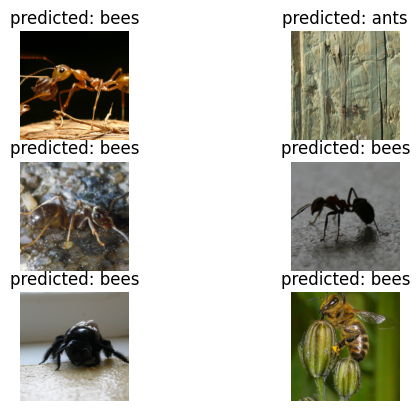

In [ ]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval() # Set model to evaluation mode
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad(): # No need to track gradients during inference
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')

                # Helper to unnormalize and show the tensor image
                img = inputs.cpu().data[j].numpy().transpose((1, 2, 0))
                mean = np.array([0.485, 0.456, 0.406])
                std = np.array([0.229, 0.224, 0.225])
                img = std * img + mean
                img = np.clip(img, 0, 1)
                plt.imshow(img)

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

# Run the inference
visualize_model(model_conv)
plt.show()

#Fine-Tuning Strategy

Alternatively, if we had a larger dataset, we could Fine-Tune the model. In this scenario, we do not freeze the weights. Instead, we let the optimizer update the entire network with a very low learning rate so it slightly 'nudges' the pre-trained knowledge toward our specific images.

In [ ]:
# Initialize another model instance for Fine-Tuning
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

# Notice we pass ALL parameters to the optimizer here, not just the head
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

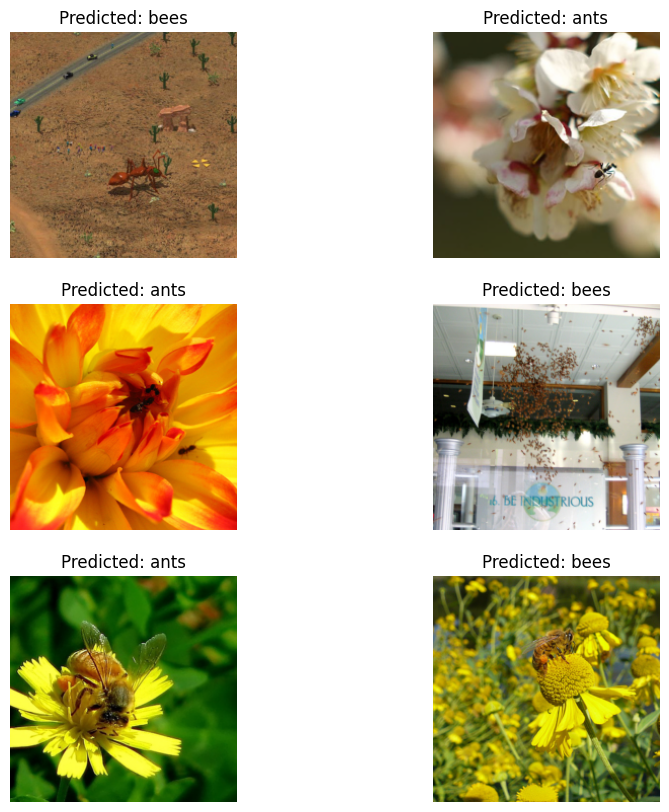

In [ ]:
def visualize_model_ft(model, num_images=6):
    was_training = model.training
    model.eval()  # Set to evaluation mode for inference
    images_so_far = 0
    fig = plt.figure(figsize=(10, 10))

    with torch.no_grad():  # Turn off gradient tracking to save memory
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images // 2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'Predicted: {class_names[preds[j]]}')

                # Unnormalize and display image
                img = inputs.cpu().data[j].numpy().transpose((1, 2, 0))
                mean = np.array([0.485, 0.456, 0.406])
                std = np.array([0.229, 0.224, 0.225])
                img = std * img + mean
                img = np.clip(img, 0, 1)
                plt.imshow(img)

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

# Execute inference on the fine-tuned model
visualize_model_ft(model_ft)
plt.show()